# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = []
    LAST_LAYER = 'conv_7b'
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.7976 - accuracy: 0.7330

947/947 [==============================] - 3513s 4s/step - loss: 0.7976 - accuracy: 0.7330 - val_loss: 0.7270 - val_accuracy: 0.7646
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.7628

947/947 [==============================] - 3360s 4s/step - loss: 0.6925 - accuracy: 0.7628 - val_loss: 0.6689 - val_accuracy: 0.7728
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6389 - accuracy: 0.7771

947/947 [==============================] - 3229s 3s/step - loss: 0.6389 - accuracy: 0.7771 - val_loss: 0.6541 - val_accuracy: 0.7757
Epoch 4/200
947/947 [==============================] - 2912s 3s/step - loss: 0.6103 - accuracy: 0.7873 - val_loss: 0.7122 - val_accuracy: 0.7579
Epoch 5/200
947/947 [==============================] - 2724s 3s/step - loss: 0.5841 - accuracy: 0.7957 - val_loss: 0.7288 - val_accuracy: 0.7530
Epoch 6/200
947/947 [==============================] - 2464s 3s/step - loss: 0.5941 - accuracy: 0.7941 - val_loss: 1.8712 - val_accuracy: 0.6835
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.7875

947/947 [==============================] - 2537s 3s/step - loss: 0.6175 - accuracy: 0.7875 - val_loss: 0.5500 - val_accuracy: 0.8080
Epoch 8/200
947/947 [==============================] - 2393s 3s/step - loss: 0.5404 - accuracy: 0.8083 - val_loss: 0.6031 - val_accuracy: 0.7938
Epoch 9/200
947/947 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.8112

947/947 [==============================] - 2548s 3s/step - loss: 0.5333 - accuracy: 0.8112 - val_loss: 0.5090 - val_accuracy: 0.8223
Epoch 10/200
947/947 [==============================] - 2398s 3s/step - loss: 0.5057 - accuracy: 0.8213 - val_loss: 0.5394 - val_accuracy: 0.8032
Epoch 11/200
947/947 [==============================] - 2379s 3s/step - loss: 0.4890 - accuracy: 0.8252 - val_loss: 0.5987 - val_accuracy: 0.7850
Epoch 12/200
947/947 [==============================] - 2402s 3s/step - loss: 0.4737 - accuracy: 0.8319 - val_loss: 0.5155 - val_accuracy: 0.8177
Epoch 13/200
947/947 [==============================] - 2365s 2s/step - loss: 0.4595 - accuracy: 0.8356 - val_loss: 1.1097 - val_accuracy: 0.7764
Epoch 14/200
947/947 [==============================] - 2351s 2s/step - loss: 0.4630 - accuracy: 0.8344 - val_loss: 0.5187 - val_accuracy: 0.8222
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.4358 - accuracy: 0.8423

947/947 [==============================] - 2465s 3s/step - loss: 0.4358 - accuracy: 0.8423 - val_loss: 0.4662 - val_accuracy: 0.8367
Epoch 16/200
947/947 [==============================] - 2378s 3s/step - loss: 0.4269 - accuracy: 0.8459 - val_loss: 0.4969 - val_accuracy: 0.8304
Epoch 17/200
947/947 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.8574

947/947 [==============================] - 2495s 3s/step - loss: 0.4065 - accuracy: 0.8574 - val_loss: 0.4593 - val_accuracy: 0.8354
Epoch 18/200
947/947 [==============================] - ETA: 0s - loss: 0.3951 - accuracy: 0.8581

947/947 [==============================] - 2463s 3s/step - loss: 0.3951 - accuracy: 0.8581 - val_loss: 0.4580 - val_accuracy: 0.8382
Epoch 19/200
947/947 [==============================] - 2347s 2s/step - loss: 0.3756 - accuracy: 0.8625 - val_loss: 0.4919 - val_accuracy: 0.8353
Epoch 20/200
947/947 [==============================] - 2340s 2s/step - loss: 0.3622 - accuracy: 0.8705 - val_loss: 0.5669 - val_accuracy: 0.8190
Epoch 21/200
947/947 [==============================] - 2389s 3s/step - loss: 0.3525 - accuracy: 0.8715 - val_loss: 0.5129 - val_accuracy: 0.8354
Epoch 22/200
947/947 [==============================] - ETA: 0s - loss: 0.4501 - accuracy: 0.8423

947/947 [==============================] - 2455s 3s/step - loss: 0.4501 - accuracy: 0.8423 - val_loss: 0.4350 - val_accuracy: 0.8435
Epoch 23/200
947/947 [==============================] - 2345s 2s/step - loss: 0.3563 - accuracy: 0.8720 - val_loss: 0.4671 - val_accuracy: 0.8393
Epoch 24/200
947/947 [==============================] - ETA: 0s - loss: 0.3307 - accuracy: 0.8797

947/947 [==============================] - 2456s 3s/step - loss: 0.3307 - accuracy: 0.8797 - val_loss: 0.4309 - val_accuracy: 0.8486
Epoch 25/200
947/947 [==============================] - 2346s 2s/step - loss: 0.3238 - accuracy: 0.8832 - val_loss: 0.4661 - val_accuracy: 0.8382
Epoch 26/200
947/947 [==============================] - 2344s 2s/step - loss: 0.3062 - accuracy: 0.8891 - val_loss: 0.4994 - val_accuracy: 0.8262
Epoch 27/200
947/947 [==============================] - 2340s 2s/step - loss: 0.2976 - accuracy: 0.8929 - val_loss: 0.4574 - val_accuracy: 0.8444
Epoch 28/200
947/947 [==============================] - 2342s 2s/step - loss: 0.2848 - accuracy: 0.8972 - val_loss: 0.4979 - val_accuracy: 0.8353
Epoch 29/200
947/947 [==============================] - 2347s 2s/step - loss: 0.2975 - accuracy: 0.8922 - val_loss: 0.4801 - val_accuracy: 0.8452
Epoch 30/200
947/947 [==============================] - 2344s 2s/step - loss: 0.2786 - accuracy: 0.8971 - val_loss: 0.4739 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 261s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9752861260952708,
 'basal cell carcinoma': 0.9869651196397876,
 'dermatofibroma': 0.988410991636798,
 'melanoma': 0.938520602800173,
 'nevus': 0.9672173770087966,
 'pigmented benign keratosis': 0.988260605703015,
 'seborrheic keratosis': 0.9577578593650945,
 'solar lentigo': 0.9575193282899659,
 'squamous cell carcinoma': 0.9804694221702172,
 'vascular lesion': 0.9987183165949306}

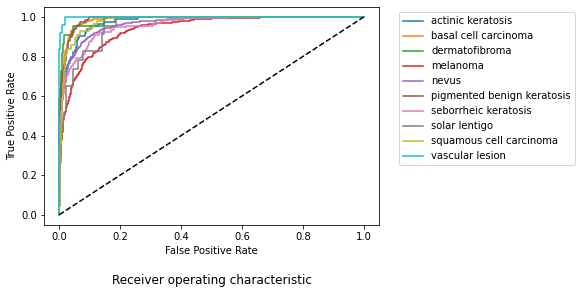

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

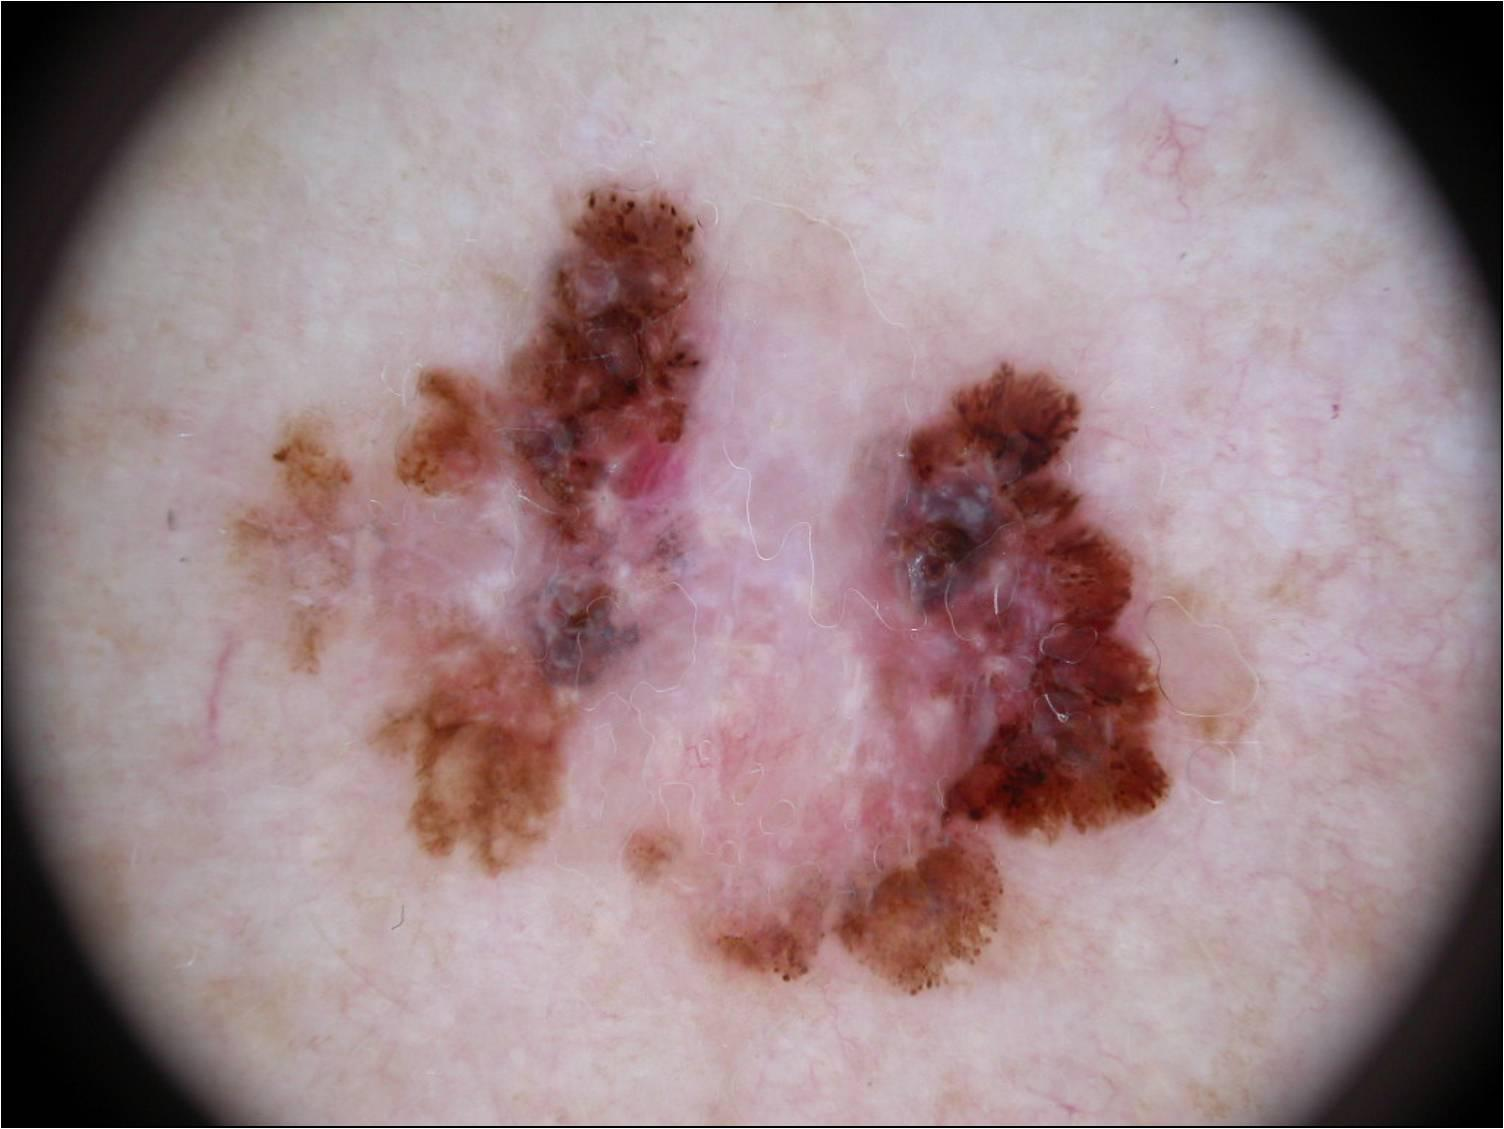

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

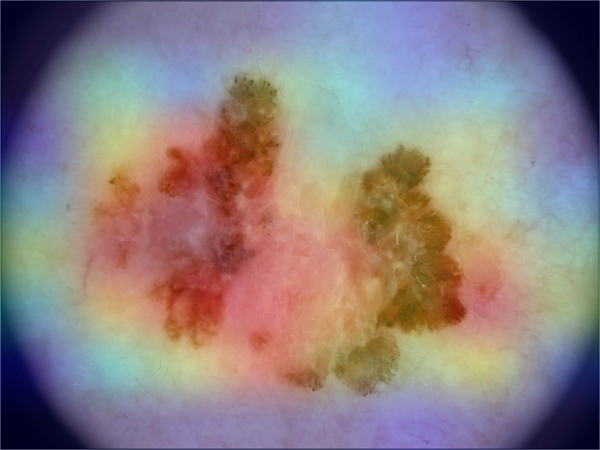

In [23]:
display_gradcam(melanoma_im_path, heatmap)